# Averaging And Sorting Data

### Finding The Averages

In [6]:
import pandas as pd
import numpy as np
from os.path import exists
from functools import reduce
import datetime
import warnings
warnings.filterwarnings("ignore")#there are some warnings that show up from pandas that don't effect us, so we just mute them

#authored by Tom Odem on 12 November 2023
#computes the averages of data over a set increments of time for users, then merges averages with respective depression measurements
def get_and_avg_data(avg_over_n_days = 7):
#avg_over_n_days: integer value of the amount of days to compute averages over. defaults to 7, which computes weekly averages
    
    users_df = pd.read_csv('user_information.csv') #read the user_information.csv file to get user ids, depression scores, etc
    n_days_df = pd.DataFrame(columns=['user_id','avg_step','avg_sleep','avg_drink', 'avg_eat','avg_care']) #initialize the dataframe that will hold averages over n days

    #go through all users in user_information.csv
    for user in np.unique(users_df['user_id']):
        if(exists('user_data/data_'+str(user)+'.csv')): #if the user's data csv exists then open it and continue
            user_df = pd.read_csv('user_data/data_'+str(user)+'.csv')
            
            #find daily step count
            user_df['client_time']= [pd.to_datetime(i).date() for i in user_df['client_time']]#turn the datetime entries into just dates
            steps= user_df.groupby(['client_time'])['step'].max().reset_index().rename(columns={'client_time':'date'}).astype({'date':object})#compute the daily step count by just taking the maximum step count everyday, rename client_time to date so we can merge with others, force date to be object for merging
            
            if(exists('user_tags/'+str(user)+'.csv')): #if the user's tags csv exists then open it and continue
                u = pd.read_csv('user_tags/'+str(user)+'.csv')
                u = u.drop(columns=['end'])


                #find daily sleep time
                #finds the time the user wakes up everyday
                wakeup_time = u.loc[(u['labelName'] == 'Wake up')]
                wakeup_time['start'] = [pd.to_datetime(t)  for t in wakeup_time['start']]
                wakeup_time['date']= [pd.to_datetime(t).date() for t in wakeup_time['start']]
                wakeup_time['hour']= [pd.to_datetime(t).time() for t in wakeup_time['start']]

                #finds the time the user went to sleep everyday
                sleep_time = u.loc[(u['labelName'] == 'Sleep')]
                sleep_time['start'] = [pd.to_datetime(t) for t in sleep_time['start']]
                sleep_time['date']= [(pd.to_datetime(t)+ pd.Timedelta(days=1)).date() for t in sleep_time['start']]
                sleep_time['hour']= [pd.to_datetime(t).time() for t in sleep_time['start']]
                
                #computes the amount of time the user slept daily
                r = pd.merge(wakeup_time, sleep_time, on ='date')
                r['start_y'] = pd.to_datetime(r['start_y'])
                r['start_x'] = pd.to_datetime(r['start_x'])
                r['sleeptime'] = (-1*(r['start_y'] - r['start_x']).astype('timedelta64[m]'))/60 #find the difference between when they woke up from when they went to sleep in hours
                r = r[['sleeptime','date']].groupby('date').mean().reset_index().astype({'date':object})#we only need the date and the sleeptime, we rest the index to change it back 
                                                                                                        #to a dataframe, and we want to force teh date to be of type object so that we can always merge even if there are no entries
                
                #find daily number of times the user drank
                drinktime = u.loc[(u['labelName'] == 'Drink')] #we only want the entries that correlate to drinking
                drinktime['date'] = [pd.to_datetime(t).date() for t in drinktime['start']] #gives us the date that the drink happened, since we do not need to know the exact time
                drinktime = drinktime.rename(columns={'labelName':'drinktime'}).groupby('date').count().drop(['start'], axis = 1).reset_index().astype({'date':object}) #finds the number of times the user drank a day by grouping by the date, we drop start becase
                                                                                                                                                                        #we only need to know the date, we reset the index to turn it back into a dataframe, and we force date to be object for merging
                
                #find daily number of times the user ate
                eattime = u.loc[(u['labelName'] == 'Eat')] #we only want the entries that correlate to eating
                eattime['date'] = [pd.to_datetime(t).date() for t in eattime['start']] #gives us the date that the eat happened, since we do not need to know the exact time
                eattime = eattime.rename(columns={'labelName':'eattime'}).groupby('date').count().drop(['start'], axis = 1).reset_index().astype({'date':object}) #finds the number of times the user ate a day by grouping by the date, we drop start becase
                                                                                                                                                                #we only need to know the date, we reset the index to turn it back into a dataframe, and we force date to be object for merging
                
                #find daily number of times the user performed and act of self care
                self_care = u.loc[(u['labelName'] == 'Take shower') | (u['labelName'] == 'Go to bathroom')] #we only want the entries that correlate to self care
                self_care['date'] = [pd.to_datetime(t).date() for t in self_care['start']] #gives us the date that the self care happened, since we do not need to know the exact time
                self_care = self_care.rename(columns={'labelName':'selfcare'}).groupby('date').count().drop(['start'], axis = 1).reset_index().astype({'date':object}) #finds the number of times the user self cared a day by grouping by the date, we drop start becase
                                                                                                                                                                        #we only need to know the date, we reset the index to turn it back into a dataframe, and we force date to be object for merging

                #merge all of the daily counts on time
                data_frames = [r,drinktime,eattime,self_care,steps] #the dataframes to be merged
                data_by_day_df = reduce(lambda  left,right: pd.merge(left,right,on=['date'],how='outer'), data_frames) #pd.merge can only merge two at a time, so we have to run merge over all of the dataframes

                max_date = data_by_day_df['date'].max() #find the latest date in the dataframe

                current_date = data_by_day_df['date'].min() #we start at the earliest date in the dataframe

                
                #take averages over avg_over_n_days incriments from the first day to the last day
                while current_date < max_date: #while we haven't reached the last day
                    n_days_from_current_date = current_date+datetime.timedelta(days=avg_over_n_days) #find the day that is avg_over_n_days away from the current date

                    range = (data_by_day_df['date'] >= current_date) & (data_by_day_df['date'] < n_days_from_current_date) #define the range of dates we select from data_by_day_df 

                    #compute the averages of each activity within the given range
                    avg_sleep = np.mean(data_by_day_df.loc[range]['sleeptime'])
                    avg_drink = np.mean(data_by_day_df.loc[range]['drinktime'])
                    avg_eat = np.mean(data_by_day_df.loc[range]['eattime'])
                    avg_care = np.mean(data_by_day_df.loc[range]['selfcare'])
                    avg_step = np.mean(data_by_day_df.loc[range]['step'])

                    #add the averages to predic_df
                    temp = pd.DataFrame([[user,avg_step, avg_sleep, avg_drink, avg_eat, avg_care]], columns=['user_id','avg_step','avg_sleep','avg_drink', 'avg_eat', 'avg_care'])
                    n_days_df = pd.concat([n_days_df, temp])


                    current_date = n_days_from_current_date #our range did not include the day avg_over_n_days away, so that day is now our current day to start from


                

                
        
            else:
                print(f'no user_tags: {user}') #the tags csv was missing for this user
        else:
            print(f'no user_data: {user}') #the data csv was missing for this user


    averages_df = pd.merge(n_days_df, users_df[['user_id','depression_class', 'depression_score']], on='user_id').set_index('user_id') #merge the averages with their respective depression class and deppression score
    return averages_df

In [7]:
# example, getting averages over an increment of 5 days
averages_df = get_and_avg_data(5)
averages_df

no user_tags: 501
no user_tags: 503
no user_tags: 507
no user_tags: 520
no user_tags: 523
no user_tags: 529
no user_tags: 532
no user_tags: 544
no user_tags: 547
no user_tags: 634
no user_tags: 658
no user_tags: 661
no user_tags: 662
no user_tags: 664
no user_tags: 668


,avg_step,avg_sleep,avg_drink,avg_eat,avg_care,depression_class,depression_score
user_id,,,,,,,
230,15241.5,NaN,1.0,NaN,NaN,Normal,0.125
230,NaN,NaN,NaN,NaN,NaN,Normal,0.125
230,NaN,NaN,NaN,NaN,NaN,Normal,0.125
230,NaN,NaN,NaN,NaN,NaN,Normal,0.125
230,NaN,NaN,NaN,NaN,NaN,Normal,0.125
...,...,...,...,...,...,...,...
674,NaN,NaN,NaN,NaN,NaN,Normal,0.000
674,NaN,NaN,NaN,NaN,NaN,Normal,0.000
674,NaN,NaN,NaN,NaN,NaN,Normal,0.000


In [32]:
averages_df.iloc[1267]

avg_step            3823.6
avg_sleep             11.1
avg_drink              3.0
avg_eat                2.0
avg_care              2.75
depression_class    Normal
depression_score     0.125
Name: 650, dtype: object

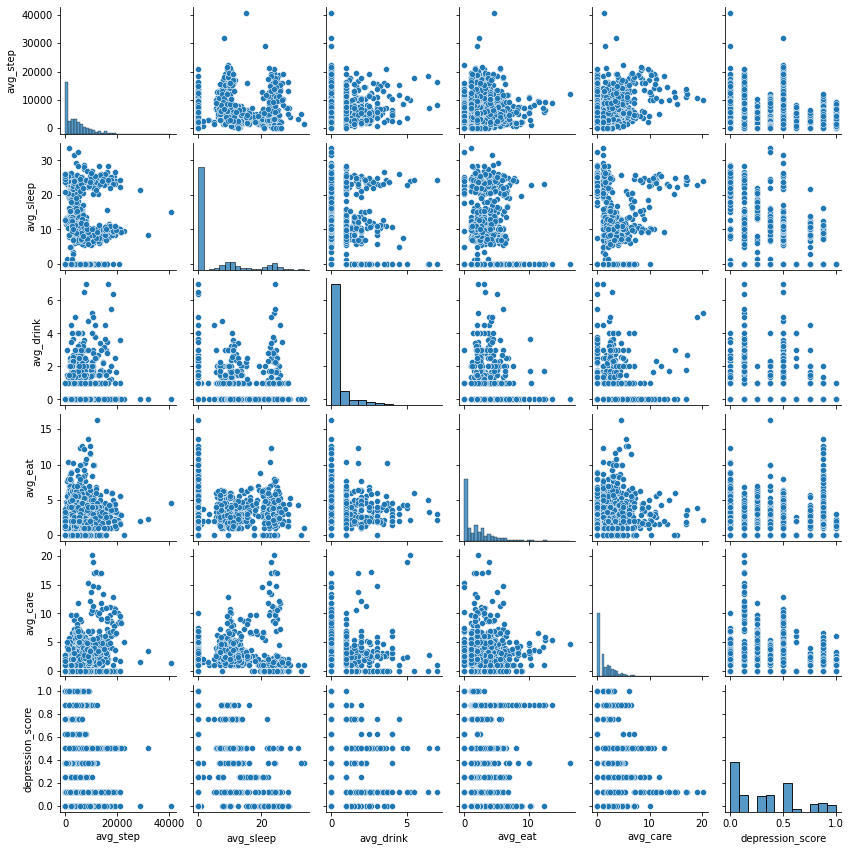

In [8]:
import seaborn as sns
sns.pairplot(data = averages_df.drop(columns={'depression_class'}).fillna(0), height = 2)  